In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import warnings
import talib as ta
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')


matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
pd.set_option('expand_frame_repr', False) # 设置输出显示格式

In [2]:
def get_mt4_data():
    path = r"D:\PythonProject\graduation_project\code\data\mt4\GBPUSD.csv"
    filename = ["EURUSD.csv", "GBPUSD.csv", "USDCHF.csv"]
    col = ["time1", "time2", "open_price", "hightest", "lowest", "close_price", "volume"]
    df = pd.read_csv(path, header=None, encoding="utf-8")
    df.columns = col
    df["time"] = pd.to_datetime(df["time1"].str.cat(df["time2"], sep=" ")) # 合并时间列
    del df["time1"]
    del df["time2"]
    df = df.sort_values("time", ascending=False).reset_index(drop=True) # 按时间列逆序排列
    df["symbol"] = "GBPUSD"
    
    multi_list = ["open_price", "hightest", "lowest", "close_price"]
    for name in multi_list:
        df[name] = (df[name] * 100000).astype(int)
    
    print("mt4 shape: ", df.shape)
    return df


def get_mt5_data(mul=True):
    path = r"D:\PythonProject\graduation_project\code\data\mt5\GBPUSD.csv"
    filename = ["EURUSD.csv", "GBPUSD.csv", "USDCHF.csv"]
    col = ["symbol", "open_price", "close_price", "hightest", "lowest", "time", "volume"]
    df = pd.read_csv(path, encoding="utf-16", sep="\t")
    df.columns = col
    df["time"] = pd.to_datetime(df["time"])
    
    multi_list = ["open_price", "hightest", "lowest", "close_price"]
    if mul:
        for name in multi_list:
            df[name] = (df[name] * 100000).astype(int)
    
    print("mt5 shape: ", df.shape)
    df = df.sort_values("time", ascending=True).reset_index(drop=True)
    return df

# mt4与mt5数据对比
def data_gap():
    df4 = get_mt4_data()
    df5 = get_mt5_data()
    # 补充时差
    df4["time"] += pd.to_timedelta(3, 'h')
    df = pd.merge(df4, df5, on=["time", "symbol"], suffixes=('_mt4', '_mt5'))
    
    gap_list = ["open_price", "hightest", "lowest", "close_price"]
    for item in gap_list:
        df[item + "_gap"] = df[item + "_mt5"] - df[item + "_mt4"]
    for item in ["_mt4", "_mt5"]:
        df["h_l_gap" + item] = df["hightest" + item] - df["lowest" + item]
        df["c_o_gap" + item] = df["close_price" + item] - df["open_price" + item]
    
    display(df.head(5))
    display(df.shape)
    draw_gap(df, gap_list)
    
def draw_gap(data: pd.DataFrame, gap_list: list):
    l_time = pd.to_datetime("2020-10-25", format="%Y-%m-%d")
    r_time = pd.to_datetime("2021-03-27", format="%Y-%m-%d")
    data = data[~((data.time >= l_time) & (data.time <= r_time))]
    display("normal data shape: ", data.shape)
    # mt5与mt4对应价格差
#     for item in gap_list:
#         plt.figure(figsize=(20, 12))
#         sns.scatterplot(x="time", y=item + "_gap", data=data, label=item+"_gap")
#         # sns.lineplot(x="time", y=item+"_gap", data=data, label=item+"_gap")
#         plt.show()
    # mt5或mt4自身价格差，最高减最低，收盘减开盘
    # 正常数据前约10w条，后约2w，中间疫情异常数据约15w
    for tp in ["h_l_gap", "c_o_gap"]:
        plt.figure(figsize=(20, 12))
        # sns.scatterplot(x="time", y=[tp+"_mt4", tp+"_mt5"], data=data, label=item+"_gap")
        sns.lineplot(x="time", y=tp+"_mt4", data=data[90700:90800], label=tp+"_gap_mt4")
        sns.lineplot(x="time", y=tp+"_mt5", data=data[90700:90800], label=tp+"_gap_mt5")
        plt.show()

In [3]:
# data_gap()

In [4]:
pd.to_datetime("2021-3-25", format="%Y-%m-%d")

Timestamp('2021-03-25 00:00:00')

In [5]:
def user_data_analysis():
    # 读取用户市场数据
    features = ['closePrice', 'closeTime', 'cmd', 'creatTime', 'openPrice', 'openTime', 'profit', 'symbol', 'ticket', 'volume']
    user_data = pd.read_excel("output2021-04-17.xls", sheet_name="history-orders-MakeMoney")
    user_data = user_data[features]
    user_data["closeTime"] = pd.to_datetime(user_data["closeTime"]).apply(lambda x: x.replace(second=0))
    user_data["openTime"] = pd.to_datetime(user_data["openTime"]).apply(lambda x: x.replace(second=0))
    
    user_data["openTime"] -= pd.to_timedelta(5, 'h')
    user_data["closeTime"] -= pd.to_timedelta(5, 'h')
    
    user_data["closePrice"] = (user_data["closePrice"] * 100000).astype(int)
    user_data["openPrice"] = (user_data["openPrice"] * 100000).astype(int)
    user_data["symbol"] = user_data["symbol"].str.replace(".ecn", "")
    # 用户市场数据头部信息
    # display(user_data.head())
    # 读取mt5价格数据
    mt5_data = get_mt5_data()
    mt5_data = mt5_data.rename(columns={"time":"openTime"})
    # 根据opentime和币种名合并
    merger_data = pd.merge(user_data, mt5_data, on=["symbol", "openTime"])
    # 缺失数据查找
    # ss = user_data[user_data.symbol=="GBPUSD"]
    # display(ss[~user_data[user_data.symbol=="GBPUSD"].openTime.isin(mt5_data.openTime)])
    fea = ["open_price", "close_price", "hightest", "lowest"]
    # 拼接后几分钟的价格数据
    for i in range(3):
        merger_data['new_time'] = merger_data.openTime + pd.to_timedelta(i+1,'min')
        new_time = merger_data.openTime + pd.to_timedelta(i+1,'min')
        i_min = mt5_data[(mt5_data.symbol=='GBPUSD')&(mt5_data.openTime.isin(new_time))]
        i_min = i_min.rename(columns={"openTime":"new_time"})
        merger_data = pd.merge(merger_data, i_min[fea + ["new_time"]],on='new_time',suffixes=('', '_' + str(i+1)))
    # 拼接收盘时的价格数据
    close_ = mt5_data[(mt5_data.symbol=='GBPUSD')&(mt5_data.openTime.isin(merger_data.closeTime))]
    close_ = close_.rename(columns={"openTime": "closeTime"})
    merger_data = pd.merge(merger_data, close_[fea + ["closeTime"]],on='closeTime',suffixes=('', '_close'))
    # display(merger_data)
    return merger_data

def cal_minute_gap(m_data: pd.DataFrame, i_min: int):
    # 计算后面分钟数据的价格差
    for i in range(i_min):
        # cmd为0表买涨，使用后分钟的hightest减去当前的lowest
        m_data.loc[m_data.cmd==0, str(i+1)+"_gap"] = m_data.loc[m_data.cmd==0, "hightest_" + str(i+1)] - m_data.loc[m_data.cmd==0, "lowest"]
        m_data.loc[m_data.cmd==1, str(i+1)+"_gap"] = m_data.loc[m_data.cmd==1, "hightest"] - m_data.loc[m_data.cmd==1, "lowest_" + str(i+1)]
    # 计算收盘时间点的价格差 close_price_close - open_price   hightest_close - lowest
    m_data.loc[m_data.cmd==0, "close_gap"] = m_data.loc[m_data.cmd==0, "hightest_close"] - m_data.loc[m_data.cmd==0, "lowest"]
    m_data.loc[m_data.cmd==1, "close_gap"] = m_data.loc[m_data.cmd==1, "hightest"] - m_data.loc[m_data.cmd==1, "lowest_close"]
    display(m_data)
    
    m_data.loc[m_data.profit >= 0, "profit_sign"] = 1
    m_data.loc[m_data.profit < 0, "profit_sign"] = -1
    m_data.loc[m_data.close_gap >= 0, "gap_sign"] = 1
    m_data.loc[m_data.close_gap < 0, "gap_sign"] = -1
    m_data["prf_gap"] = m_data["profit_sign"] * m_data["gap_sign"]
    # m_data.to_csv("gap.csv")
    return m_data

def draw_gap(gap_data: pd.DataFrame, i_m: int):
    for i in range(i_m):
        plt.figure(figsize=(20, 10))
        sns.lineplot(x="openTime", y=str(i+1) + "_gap", data=gap_data, label=str(i+1) + "_gap", alpha=0.65, markers=True)
        plt.show()
    plt.figure(figsize=(20, 10))
    sns.lineplot(x="openTime", y="close_gap", data=gap_data, label="close_gap", alpha=0.65, markers=True)
    plt.show()

def divide_data():
    df = get_mt5_data().sort_values("time", ascending=True).reset_index(drop=True)
    df_len = df.shape[0]
    train = df[:int(0.8 * df_len)]
    test = df[int(0.8 * df_len):].reset_index(drop=True)
    train.to_csv("./data/std_data/train.csv", index=False)
    test.to_csv("./data/std_data/test.csv", index=False)

In [6]:
# res = user_data_analysis()
# display(res.columns)
# res = cal_minute_gap(res, 3)
# draw_gap(res, 3)

In [7]:
# display(res["prf_gap"].value_counts())
# res[res.prf_gap == -1] # [["profit", "close_gap"]]

In [8]:
mt5_data = get_mt5_data()
close_max = mt5_data["close_price"].max()
close_min = mt5_data["close_price"].min()

# 数据集
class MyDataSet(Dataset):
    # 初始化数据
    def __init__(self, data_x, data_label):
        self.data = data_x
        self.label = data_label
    # 单条数据获取，返回data和其label，最后会根据batchsize合并一组数据
    def __getitem__(self, index):
        data = self.data[index]
        p_label = self.label[index]
        return data, p_label
    # 返回数据记录长度
    def __len__(self):
        return self.data.shape[0]

# 模型
class lstm(nn.Module):
    def __init__(self, n_s):
        super(lstm, self).__init__()
        # 模型及参数定义
        self.lstm = nn.LSTM(
            input_size=n_s,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=False,
        )
        self.linear = nn.Linear(64, 1)
        
        self.h_s = None
        self.h_c = None
    
    def forward(self, x):
        # 模型最后输出，包括隐藏层输出和记忆单元的最后输出
        out, (self.h_s, self.h_c) = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out
    
    
# 将数据转换为有监督的数据，即添加label
def data_change(data: torch.Tensor, seq_len=14, label_col="close_price", slip=0.8):
    total_len, col_len = data.shape
    slip = int(slip * total_len)
    x = torch.zeros(total_len - seq_len, seq_len, col_len)
    y = torch.zeros(total_len - seq_len, 1, 1)
    for i in range(total_len - seq_len):
        x[i] = data[i: i+seq_len]
        y[i] = data[i+seq_len: i+seq_len+1][:, 0].reshape(-1, 1)
    
    x_train = x[0: slip]
    y_train = y[0: slip]
    x_val = x[slip:]
    y_val = y[slip:]
    print("data change finish...")
    return x_train, y_train, x_val, y_val

# 数据处理
def data_processing(df_train: pd.DataFrame, df_test=None):
    idx = "close_price"
    # 10日ma
    for i in range(1, 11):
        df_train[idx+'_ma_'+str(i)] = df_train[idx].rolling(window=i).mean()
    # 12日和26日ema
    df_train[idx+'_ema_12'] = df_train[idx].ewm(span=12, adjust=False).mean()
    df_train[idx+'_ema_26'] = df_train[idx].ewm(span=26, adjust=False).mean()
    # 计算dif，dea，macd
    df_train[idx+"_dif"], df_train[idx+"_dea"], df_train[idx+"_macd"] = ta.MACD(
                                                        df_train[idx], fastperiod=12, slowperiod=26, signalperiod=9)
    # 计算rsi,周期取14
    df_train[idx+"_rsi"] = ta.RSI(df_train[idx], timeperiod=14)
    # kdj指标
    low_list = df_train['lowest'].rolling(9, min_periods=9).min()
    low_list.fillna(value = df_train['lowest'].expanding().min(), inplace = True)
    high_list = df_train['hightest'].rolling(9, min_periods=9).max()
    high_list.fillna(value = df_train['hightest'].expanding().max(), inplace = True)
    rsv = (df_train[idx] - low_list) / (high_list - low_list) * 100

    df_train['K'] = pd.DataFrame(rsv).ewm(com=2).mean()
    df_train['D'] = df_train['K'].ewm(com=2).mean()
    df_train['J'] = 3 * df_train['K'] - 2 * df_train['D']
    
    df_train = df_train.dropna()
    
    # 归一化
    scaler = MinMaxScaler()
    scaler = scaler.fit(df_train)
    df_train = scaler.transform(df_train)
    if df_test:
        df_test = scaler.transform(df_test)
    
    return df_train, df_test

# 转换数据格式为DataLoader，以作为lstm模型的输入
def get_data_loader(ori_data: pd.DataFrame, batch_size=64):
    data_len = ori_data.shape[1]
    # 转化为tensor格式
    ori_data = np.array(ori_data, dtype=np.float32)
    ori_data = torch.tensor(ori_data)
    # 构造数据集并划分
    x_train, y_train, x_val, y_val = data_change(ori_data)
    # 转化为dataset格式
    train_set = MyDataSet(x_train, y_train)
    valid_set = MyDataSet(x_val, y_val)
    # 构造dataloader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
    print("train_loader len(batch-64): ", len(train_loader))
    print("valid_loader len(batch-64): ", len(valid_loader))
    print("data loader finish...")
    return train_loader, valid_loader, data_len

def train_model(data: pd.DataFrame):
    epochs = 30  # 迭代次数
    lr = 3e-4  # 初始学习率
    best_precision = 1e6  # 记录最好模型
    lr_epoch = [5, 10, 15, 20, 25]
    
    train_loader, valid_loader, data_len = get_data_loader(data)
    
    model = lstm(data_len)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    print("begin training...")
    for epc in range(epochs):
        # 学习率衰减
        if epc in lr_epoch:
            lr = lr * 0.5
        optimizer.lr = lr
        train_loss, valid_loss = 0, 0
        
        model.train()
        # 遍历batch训练模型。计算梯度并反向传播更新参数
        for i, (input_x, input_y) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(input_x)
            input_y = input_y.squeeze(1)
            loss = loss_function(pred, input_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        preds = []
        labels = []
        model.eval()
        with torch.no_grad():  # 只看验证集结果 而不进行反向传播的计算
            for i, (input_x, input_y) in enumerate(valid_loader):
                pred = model(input_x)
                
                preds.extend((pred.squeeze(1) * (close_max - close_min) + close_min).tolist())
                labels.extend((input_y.squeeze(1) * (close_max - close_min) + close_min).tolist())
                
                input_y = input_y.squeeze(1)
                loss = loss_function(pred, input_y)
                valid_loss += loss.item()
        print("[%2d/%2d] train loss: %.5f --- val loss: %.5f --- " % (epc+1, epochs, train_loss, valid_loss), end='')
        mae_score = mean_absolute_error(preds, labels)
        print("val mae: %.5f" % mae_score)
        
        is_best = valid_loss < best_precision
        best_precision = min(valid_loss, best_precision)
        if is_best:
            torch.save({'model': model, 'preds': preds, 'labels': labels, 'loss': valid_loss}, './model_save/lstm.model')


def data_prepare_nocut(label_col="close_price"):
    ori_data = get_mt5_data()
    use_list = ["symbol", "time", "volume"]
    use_list = list(set(ori_data.columns) - set(use_list))
    ori_data = ori_data[use_list]
    ori_data, _ = data_processing(ori_data)
    return ori_data


def main():
    train_data = data_prepare_nocut()
    train_model(train_data)
    


mt5 shape:  (1000000, 7)


In [9]:
# main()

In [10]:
# 模型预测
# def model_predict(test_data: pd.DataFrame, idx=1):
#     test_data = np.array(test_data, dtype=np.float32)
#     test_data = torch.tensor(test_data)
#     test_set = MyDataSet(test_data, test_data[:, idx])
#     test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    
#     best_model = torch.load('./model_save/lstm.model').get('model')
#     best_model.eval()
    
#     preds = []
#     labels = []
#     for i, (x, label) in enumerate(test_loader):
#         x = x.unsqueeze(1)
#         pred = best_model(x)
#         preds.extend(pred.squeeze(1).tolist())
#         labels.extend(label.tolist())
#     display(preds)
#     display(labels)


# def data_prepare(label_col="close_price"):
#     # 获取m5数据
#     ori_data = get_mt5_data()
#     # 去除无关列
#     use_list = ["symbol", "time", "volume"]
#     use_list = list(set(ori_data.columns) - set(use_list))
#     ori_data = ori_data[use_list]
#     # 划分训练集和测试集
#     data_len = ori_data.shape[0]
#     train_data = ori_data[:int(0.8 * data_len)]
#     test_data = ori_data[int(0.8 * data_len):]
#     idx = list(test_data.columns).index(label_col)
#     # 数据处理
#     train_data, test_data = data_processing(train_data, test_data)
#     return train_data, test_data, idx

In [11]:
preds = torch.load('./model_save/lstm.model').get('preds')
lab = torch.load('./model_save/lstm.model').get('labels')

In [13]:
df = get_mt5_data()
df = df[-5000:]
df.index = df.time
train = df[:-60]
valid = df[-60:]
train = train[['close_price']]
valid = valid[['close_price']]

from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

mt5 shape:  (1000000, 7)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=41785.655, Time=2.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41794.028, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41792.911, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41792.959, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41792.358, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=41788.898, Time=2.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41796.626, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=41787.342, Time=3.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=41787.347, Time=3.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41790.750, Time=1.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=41788.335, Time=2.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=41797.806, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=41789.340, Time=4.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=41784.226, Time=1.2

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

ARIMA mae:  48.91860889800446


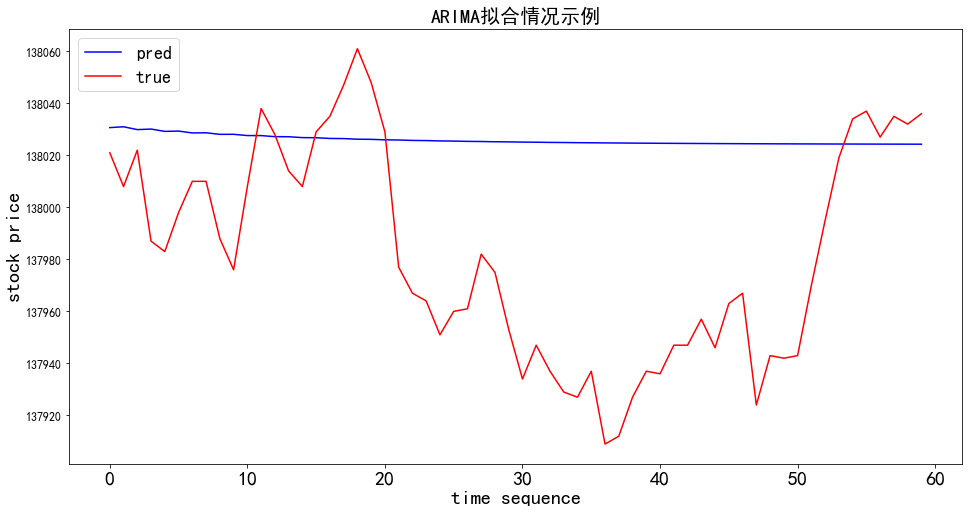

In [15]:
pred = model.predict(n_periods=60)

mae_ = mean_absolute_error(pred, valid)
print("ARIMA mae: ", mae_)

plt.figure(figsize=(16, 8))
plt.plot(pred, "b", label="pred")
plt.plot(list(valid['close_price']), "r", label="true")

plt.legend(loc=2,fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.xlabel('time sequence',fontsize=20)
plt.ylabel('stock price',fontsize=20)
plt.title('ARIMA拟合情况示例',fontsize=20)
# plt.savefig('./picture/arima.png',dpi=500, bbox_inches='tight')
plt.show()

In [12]:
df.head()

,symbol,open_price,close_price,hightest,lowest,time,volume
time,,,,,,,
2021-01-11 02:14:00,GBPUSD,135245,135226,135246,135222,2021-01-11 02:14:00,51
2021-01-11 02:15:00,GBPUSD,135225,135240,135260,135224,2021-01-11 02:15:00,72
2021-01-11 02:16:00,GBPUSD,135240,135216,135248,135212,2021-01-11 02:16:00,105
2021-01-11 02:17:00,GBPUSD,135216,135217,135219,135194,2021-01-11 02:17:00,92
2021-01-11 02:18:00,GBPUSD,135217,135238,135247,135215,2021-01-11 02:18:00,96


In [12]:
df = get_mt5_data()
df = df[:]
df.index = df.time
ml_train = df[['open_price','close_price','hightest','lowest']]

ml_train['price_DIFF'] = ml_train['close_price'] - ml_train['open_price']
ml_train['most_DIFF'] = ml_train['hightest'] - ml_train['lowest']


idx = "close_price"
# 10日ma
# for i in range(1, 11):
#     ml_train[idx+'_ma_'+str(i)] = ml_train[idx].rolling(window=i).mean()
# # 12日和26日ema
# ml_train[idx+'_ema_12'] = ml_train[idx].ewm(span=12, adjust=False).mean()
# ml_train[idx+'_ema_26'] = ml_train[idx].ewm(span=26, adjust=False).mean()
# # 计算dif，dea，macd
# ml_train[idx+"_dif"], ml_train[idx+"_dea"], ml_train[idx+"_macd"] = ta.MACD(
#                                                     ml_train[idx], fastperiod=12, slowperiod=26, signalperiod=9)
# # 计算rsi,周期取14
# ml_train[idx+"_rsi"] = ta.RSI(ml_train[idx], timeperiod=14)
# # kdj指标
# low_list = ml_train['lowest'].rolling(9, min_periods=9).min()
# low_list.fillna(value = ml_train['lowest'].expanding().min(), inplace = True)
# high_list = ml_train['hightest'].rolling(9, min_periods=9).max()
# high_list.fillna(value = ml_train['hightest'].expanding().max(), inplace = True)
# rsv = (ml_train[idx] - low_list) / (high_list - low_list) * 100

# ml_train['K'] = pd.DataFrame(rsv).ewm(com=2).mean()
# ml_train['D'] = ml_train['K'].ewm(com=2).mean()
# ml_train['J'] = 3 * ml_train['K'] - 2 * ml_train['D']

# ml_train = ml_train.dropna()


ml_train['label'] = ml_train.close_price.shift(-1)
ml_train.drop('close_price',axis=1)
# ml_train['label'] = ml_train.close_price.shift(-1)
# ml_train['label'] = ml_train.label - ml_train.close_price
ml_train = ml_train.dropna()

mt5 shape:  (1000000, 7)


In [13]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(ml_train.drop('label',axis=1),ml_train.label,test_size=0.3,
                                                 random_state=111,shuffle=False)
display(test_y)

time
2020-06-25 17:46:00    124146.0
2020-06-25 17:47:00    124132.0
2020-06-25 17:48:00    124131.0
2020-06-25 17:49:00    124112.0
2020-06-25 17:50:00    124111.0
                         ...   
2021-04-16 16:38:00    138037.0
2021-04-16 16:39:00    138027.0
2021-04-16 16:40:00    138035.0
2021-04-16 16:41:00    138032.0
2021-04-16 16:42:00    138036.0
Name: label, Length: 300000, dtype: float64

LinearRegression MAE: 13.708103290054096


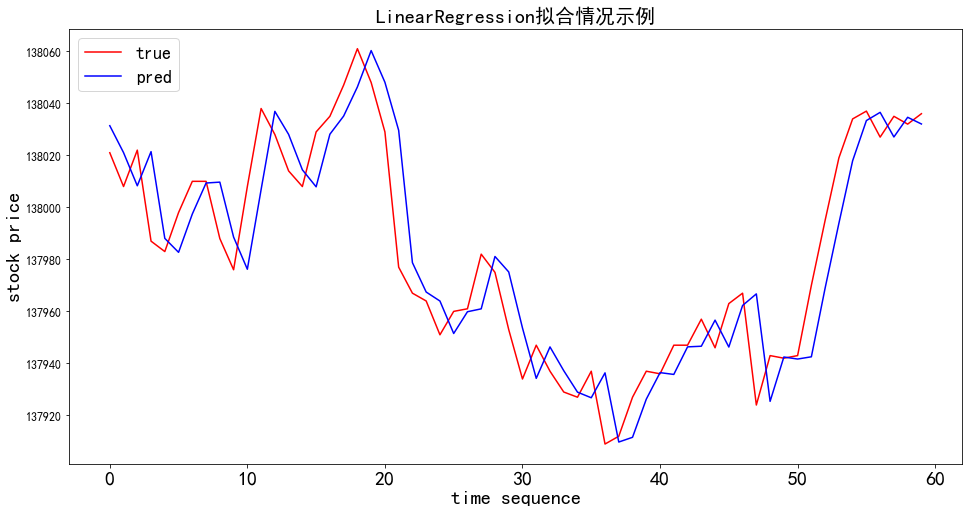

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

lin_model = LinearRegression()

lin_model.fit(train_x,train_y)
print('LinearRegression MAE:',mean_absolute_error(lin_model.predict(test_x),test_y))
plt.figure(figsize=(16, 8))

plt.plot(list(test_y)[-60:], "r", label="true")
plt.plot(lin_model.predict(test_x)[-60:], "b", label="pred")

plt.legend(loc=2,fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.xlabel('time sequence',fontsize=20)
plt.ylabel('stock price',fontsize=20)
plt.title('LinearRegression拟合情况示例',fontsize=20)
plt.savefig('./picture/Linear.png',dpi=500, bbox_inches='tight')

plt.show()
# display(list(test_y)[-60:])
# display(lin_model.predict(test_x)[-60:])

In [1]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

ml_train = df[['open_price','close_price','hightest','lowest']]


# ml_train['price_DIFF'] = ml_train['close_price'] - ml_train['open_price']
# ml_train['most_DIFF'] = ml_train['hightest'] - ml_train['lowest']


idx = "close_price"
# 10日ma
for i in range(1, 11):
    ml_train[idx+'_ma_'+str(i)] = ml_train[idx].rolling(window=i).mean()
# 12日和26日ema
ml_train[idx+'_ema_12'] = ml_train[idx].ewm(span=12, adjust=False).mean()
ml_train[idx+'_ema_26'] = ml_train[idx].ewm(span=26, adjust=False).mean()
# 计算dif，dea，macd
ml_train[idx+"_dif"], ml_train[idx+"_dea"], ml_train[idx+"_macd"] = ta.MACD(
                                                    ml_train[idx], fastperiod=12, slowperiod=26, signalperiod=9)
# 计算rsi,周期取14
ml_train[idx+"_rsi"] = ta.RSI(ml_train[idx], timeperiod=14)
# kdj指标
low_list = ml_train['lowest'].rolling(9, min_periods=9).min()
low_list.fillna(value = ml_train['lowest'].expanding().min(), inplace = True)
high_list = ml_train['hightest'].rolling(9, min_periods=9).max()
high_list.fillna(value = ml_train['hightest'].expanding().max(), inplace = True)
rsv = (ml_train[idx] - low_list) / (high_list - low_list) * 100

ml_train['K'] = pd.DataFrame(rsv).ewm(com=2).mean()
ml_train['D'] = ml_train['K'].ewm(com=2).mean()
ml_train['J'] = 3 * ml_train['K'] - 2 * ml_train['D']


ml_train['label'] = ml_train.close_price.shift(-1)
ml_train['label'] = ml_train.label - ml_train.close_price
ml_train = ml_train.dropna()
train_x,test_x,train_y,test_y = train_test_split(ml_train.drop('label',axis=1),ml_train.label,test_size=0.3,
                                                 random_state=111,shuffle=False)


model = LGBMRegressor(n_estimators=100000)
model.fit(train_x,train_y,eval_set=(test_x,test_y),eval_metric='mae',early_stopping_rounds=500,verbose=100)
pred = model.predict(test_x)
print("lgb mae: ", mean_absolute_error(pred + test_x.close_price, test_y + test_x.close_price))

plt.plot(list(test_x.close_price)[-60:], "r", label="true")
plt.plot(list(pred + test_x.close_price)[-60:], "b", label="pred")
plt.show()

NameError: name 'df' is not defined